# Mapas Covid

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
#import seaborn as sns
import os
import geopandas as gpd
import geoplot
import mapclassify
from tensorflow.keras.utils import get_file

## Carregando dados
Utilizando planilha do [Portal sobre Covid19 do Ministério da Saúde]('https://covid.saude.gov.br/')

In [2]:
df = pd.read_excel('./data/HIST_PAINEL_COVIDBR_25jun2020.xlsx')
# tratamento inicial dos valores de população
df['populacaoTCU2019'] = df['populacaoTCU2019'].fillna('0')
df['populacaoTCU2019'] = df['populacaoTCU2019'].str.split(pat='(', expand=True )
df['populacaoTCU2019'] = df['populacaoTCU2019'].str.replace('.','').astype(int)

### Dias de semana como varíável categórica 

In [3]:
cat_dia_semana = pd.CategoricalDtype(categories=['seg', 'ter', 'qua', 'qui', 'sex', 'sab', 'dom'], ordered=True)
df['dia_semana'] = df['data'].dt.dayofweek
df['dia_semana_nm'] = df['dia_semana'].replace({0:'seg', 1: 'ter', 2:'qua', 3:'qui', 4:'sex', 5:'sab', 6:'dom'}).astype(cat_dia_semana)

## Entre com a silga do estado e o nome da cidade

In [4]:
uf = 'Ba'
Muni = 'Salvador'

### Função de tratamento dos dados
* recebe o banco de dados, a sigla do estado e o nome da cidade
* retorna:
    1. DataFrame do estado
    1. DataFrame do estado agregado por semana epidemiológica
    1. DataFrame da cidade
    1. DataFrame da cidade agregado por semana epidemiológica


In [5]:
def semana_epi_df(df,estado, cidade):
    fltr = df['estado'].str.lower() == estado.lower()
    df_UF = df.loc[fltr, :]
    df_UF_sem = df_UF.groupby('semanaEpi')
    df_UF_sem = df_UF_sem.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'}).reset_index()
    fltr = df_UF['municipio'].str.lower() == cidade.lower()
    df_muni = df_UF.loc[fltr, :]
    df_muni_sem = df_muni.groupby('semanaEpi')
    df_muni_sem = df_muni_sem.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'}).reset_index()
    return df_UF, df_UF_sem, df_muni, df_muni_sem

In [6]:
df_est, df_est_sem, df_cidade, df_cidade_sem = semana_epi_df(df, uf, Muni)

In [78]:

def casos_acumulados(df_muni, muni):
    df_muni.sort_values('data', inplace = True)
    df_muni['ca_log'] = df_muni['casosAcumulado'].apply(lambda x: np.log10(x))
    dia_0 = df_muni['data'].min()
    df_muni['dia_num'] = (df_muni['data'] - dia_0).apply(lambda x: x.days)
### figura 01 -casos acumulados por dia
    plt.figure(1, figsize=(10,10))
    plt.title('{}: \n Casos Acumulados por Dia'.format(muni).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.plot('data', 'casosAcumulado', data=df_muni, color= 'royalblue', linewidth=7)
    plt.savefig( './data/output/' + muni + 'Casos Acumulados' + str(df_muni['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(1)
##### figura 01 -casos acumulados por dia(log)
    plt.figure(2, figsize=(10,10))
    plt.title('{}: \n Casos por Dia'.format(muni).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados por Dia(log)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.plot('data', 'ca_log', data=df_muni, color= 'royalblue', linewidth=7)
    plt.savefig( './data/output/' + muni + 'Casos Acumulados log' + str(df_muni['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(2)
    print ('dia zero', dia_0)
    print('Casos Acumulados\n',df_muni.loc[:,['casosNovos', 'data']].tail(14))
    

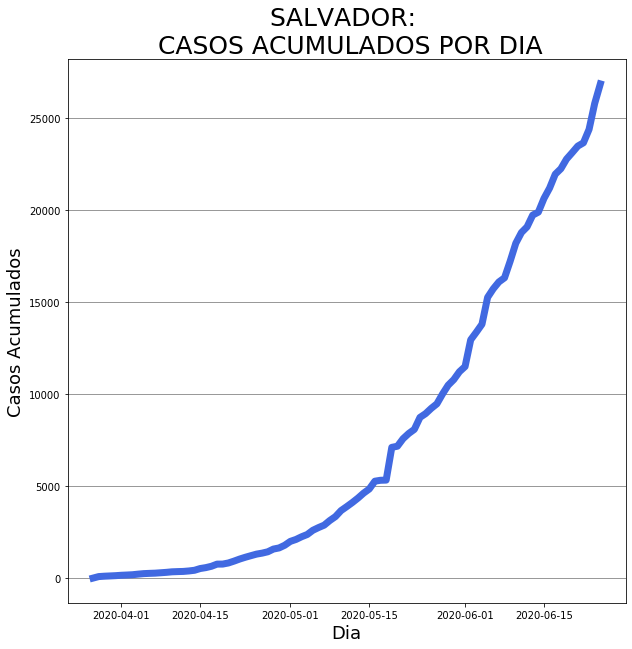

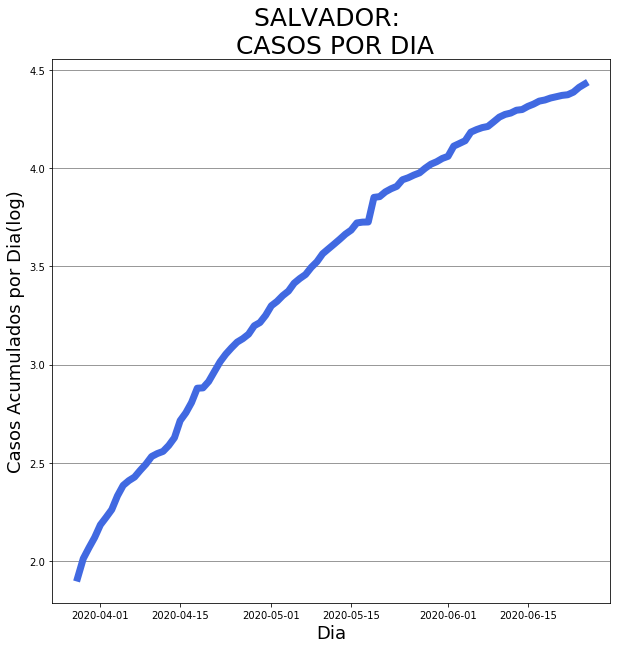

dia zero 2020-03-27 00:00:00
Casos Acumulados
         casosNovos       data
193865         309 2020-06-12
193866         639 2020-06-13
193867         161 2020-06-14
193868         745 2020-06-15
193869         565 2020-06-16
193870         752 2020-06-17
193871         299 2020-06-18
193872         523 2020-06-19
193873         347 2020-06-20
193874         359 2020-06-21
193875         180 2020-06-22
193876         730 2020-06-23
193877        1410 2020-06-24
193878        1061 2020-06-25


In [79]:
casos_acumulados(df_cidade, Muni)

### Função Grafico de casos por dia

In [74]:
def casos_dia_local(df1, local):
    df1.sort_values('data', inplace = True)
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Casos por Dia'.format(local).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Número de Casos', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('data', 'casosNovos', data=df1, color= ['r','g', 'b', 'm', 'y', 'c', 'k'], width=.8)
    plt.legend( labels=df1['dia_semana_nm'])
    plt.savefig( './data/output/' + local + '_dia_casos_' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show()
    print('Casos por dia\n',df1.loc[:,['casosNovos', 'data']].tail(14))

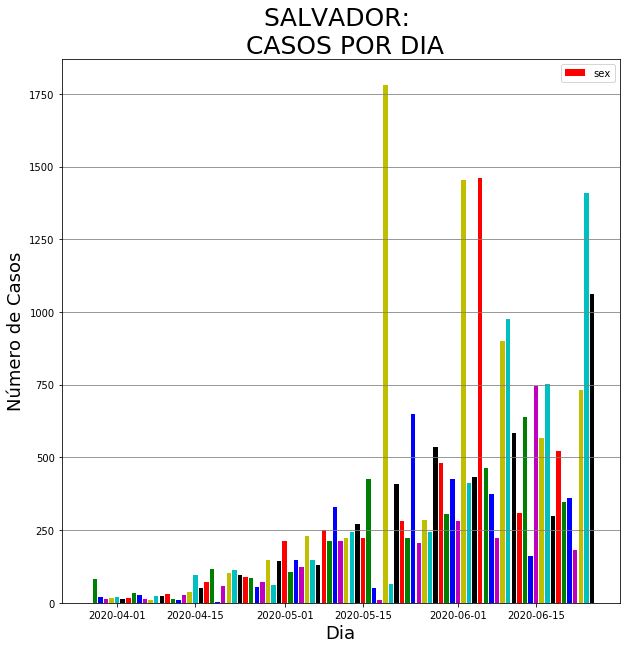

Casos por dia
         casosNovos       data
193865         309 2020-06-12
193866         639 2020-06-13
193867         161 2020-06-14
193868         745 2020-06-15
193869         565 2020-06-16
193870         752 2020-06-17
193871         299 2020-06-18
193872         523 2020-06-19
193873         347 2020-06-20
193874         359 2020-06-21
193875         180 2020-06-22
193876         730 2020-06-23
193877        1410 2020-06-24
193878        1061 2020-06-25


In [75]:
casos_dia_local(df_cidade, Muni)

### Casos por dia (média móvel de 5 dias centralizada)

In [50]:
def casos_dia_media_movel(df1, local):
    df1.sort_values('data', inplace = True)

    ###- tratando números negativos
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])

    df1['media_movel_casos'] =df1.rolling(5, center=True)['casosNovos'].mean()
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Casos por Dia (média móvel de 5 dias)'.format(local).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Número de Casos (média móvel de 5 dias)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('data', 'media_movel_casos', data=df1, color= 'teal', width=.8)
    plt.savefig( './data/output/' + local + '_dia_casos_Media_Movel' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show()
    print('Média móvel por dia\n', df1.loc[:,['media_movel_casos', 'data']].head(14))
    print(df1.loc[:,['media_movel_casos', 'data']].tail(14))

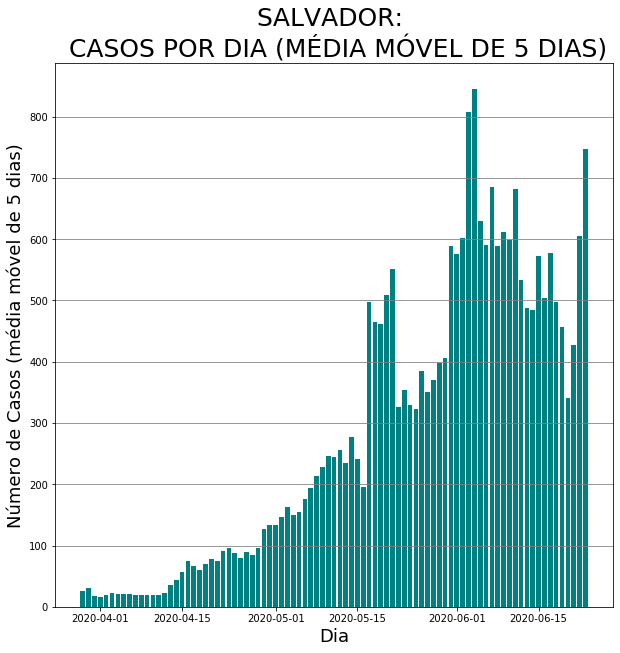

Média móvel por dia
         media_movel_casos       data
193788                NaN 2020-03-27
193789                NaN 2020-03-28
193790               26.4 2020-03-29
193791               30.6 2020-03-30
193792               17.0 2020-03-31
193793               16.0 2020-04-01
193794               19.6 2020-04-02
193795               22.2 2020-04-03
193796               20.8 2020-04-04
193797               20.2 2020-04-05
193798               21.4 2020-04-06
193799               19.4 2020-04-07
193800               19.6 2020-04-08
193801               19.2 2020-04-09
        media_movel_casos       data
193865              533.8 2020-06-12
193866              487.4 2020-06-13
193867              483.8 2020-06-14
193868              572.4 2020-06-15
193869              504.4 2020-06-16
193870              576.8 2020-06-17
193871              497.2 2020-06-18
193872              456.0 2020-06-19
193873              341.6 2020-06-20
193874              427.8 2020-06-21
193875           

In [51]:
casos_dia_media_movel(df_cidade, Muni)

In [62]:
def obitos_dia_local(df1, local):
    df1.sort_values('data', inplace = True)

    ### valores negativos de novos obitos
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])
    
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Óbitos por Dia'.format(local).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Número de Óbitos', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('data', 'obitosNovos', data=df1, color= ['r','g', 'b', 'm', 'y', 'c', 'k'], width=.8)
    plt.legend(labels=df1['dia_semana_nm'].tolist())
    plt.savefig( './data/output/' + local + '_dia_obitos_' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show()
    print('Óbitos por dia\n',df1.loc[:,['obitosNovos', 'data']].tail(14))

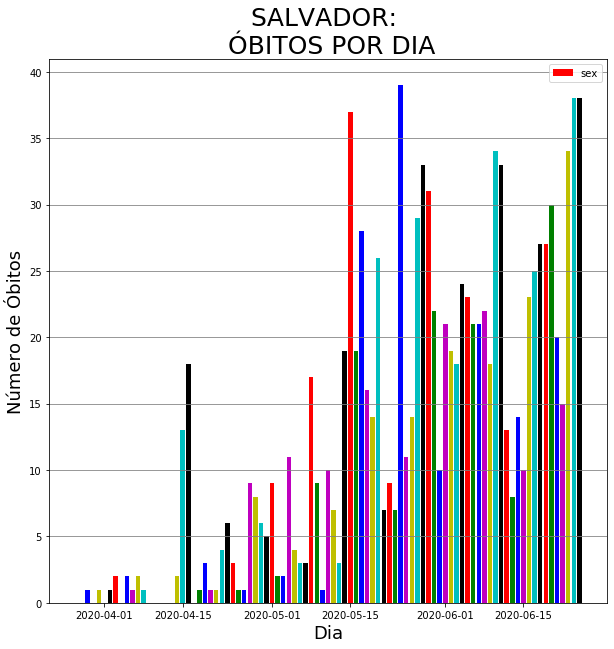

Óbitos por dia
         obitosNovos       data
193865           13 2020-06-12
193866            8 2020-06-13
193867           14 2020-06-14
193868           10 2020-06-15
193869           23 2020-06-16
193870           25 2020-06-17
193871           27 2020-06-18
193872           27 2020-06-19
193873           30 2020-06-20
193874           20 2020-06-21
193875           15 2020-06-22
193876           34 2020-06-23
193877           38 2020-06-24
193878           38 2020-06-25


In [63]:
obitos_dia_local(df_cidade, Muni)

In [48]:
def obitos_dia_media_movel(df1, local):
    df1.sort_values('data', inplace = True)
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])
    df1['media_movel_obitos'] =df1.rolling(5, center=True)['obitosNovos'].mean()
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Óbitos por Dia (média móvel de 5 dias)'.format(local).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Número de Óbitos (média móvel de 5 dias)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('data', 'media_movel_obitos', data=df1, color= 'saddlebrown', width=.8)
    plt.savefig( './data/output/' + local + '_dia_obitos_Media_Movel' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show()
    print('Média móvel por dia\n', df1.loc[:,['media_movel_obitos', 'data']].head(14))
    print(df1.loc[:,['media_movel_obitos', 'data']].tail(14))

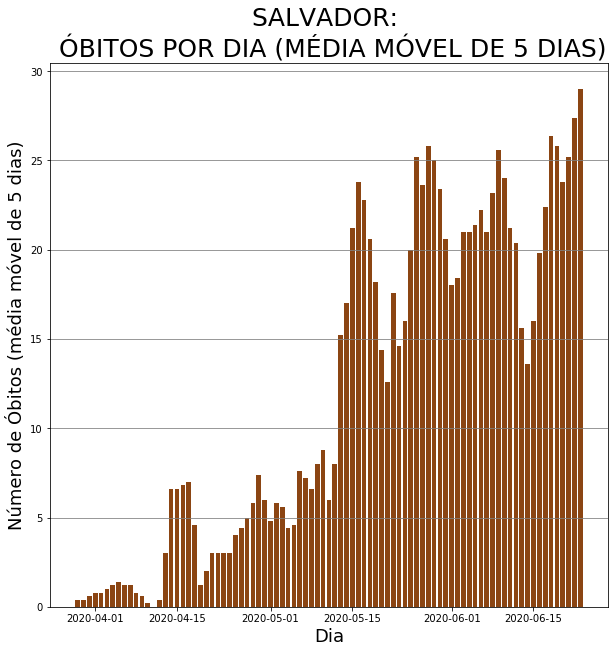

Média móvel por dia
         media_movel_obitos       data
193788                 NaN 2020-03-27
193789                 NaN 2020-03-28
193790                 0.4 2020-03-29
193791                 0.4 2020-03-30
193792                 0.6 2020-03-31
193793                 0.8 2020-04-01
193794                 0.8 2020-04-02
193795                 1.0 2020-04-03
193796                 1.2 2020-04-04
193797                 1.4 2020-04-05
193798                 1.2 2020-04-06
193799                 1.2 2020-04-07
193800                 0.8 2020-04-08
193801                 0.6 2020-04-09
        media_movel_obitos       data
193865                20.4 2020-06-12
193866                15.6 2020-06-13
193867                13.6 2020-06-14
193868                16.0 2020-06-15
193869                19.8 2020-06-16
193870                22.4 2020-06-17
193871                26.4 2020-06-18
193872                25.8 2020-06-19
193873                23.8 2020-06-20
193874                25.2 20

In [49]:
obitos_dia_media_movel(df_cidade, Muni)

### Função gráfico de casos por semana epidemiológica
* recebe:
    1. DataFrame do estado ou cidade agregado por semana epidemiológica
    1. String com o nome do local

In [17]:
def casos_semana_local(df, local):    
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Casos por Semana Epidemiológica'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Casos', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('semanaEpi', 'casosNovos', data=df, color= 'seagreen', width=.5)
    plt.savefig( './data/output/' + local + '_semana_casos_' + str(df['semanaEpi'].max()) + '.png', format ='png')
    plt.show()
    print('Casos por semana epidemiológica\n',df.loc[:,['semanaEpi','casosNovos']])

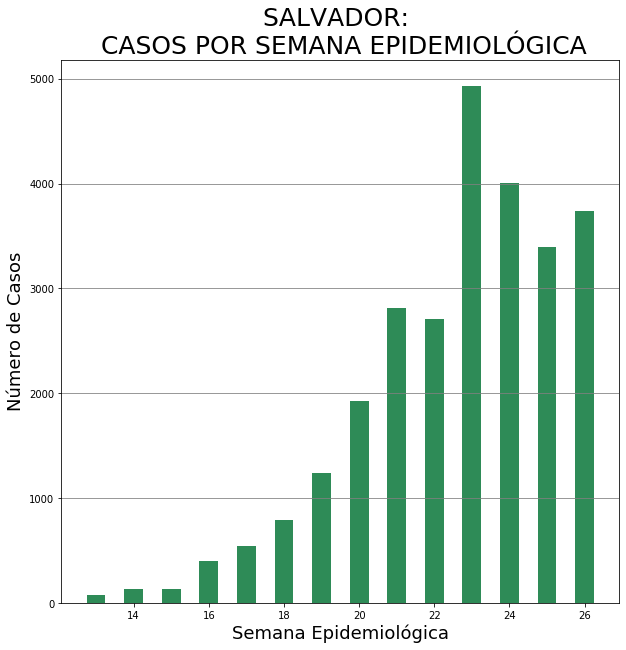

Casos por semana epidemiológica
     semanaEpi  casosNovos
0          13          82
1          14         133
2          15         138
3          16         406
4          17         544
5          18         797
6          19        1242
7          20        1925
8          21        2817
9          22        2707
10         23        4933
11         24        4008
12         25        3392
13         26        3740


In [18]:
casos_semana_local(df_cidade_sem, Muni)

### Função gráfico de óbitos por semana epidemiológica
* recebe:
    1. DataFrame do estado ou cidade agregado por semana epidemiológica
    1. String com o nome do local

In [19]:
def obitos_semana_local(df, local):     
    plt.figure(figsize=(10,10))
    plt.grid(axis='y', color='grey')
    plt.title('{}: \n Óbitos por Semana Epidemiológica'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Óbitos', fontsize=18)
    plt.bar('semanaEpi', 'obitosNovos', data=df, color= 'dimgray', width=.5)
    plt.savefig( './data/output/' + local + '_semana_obitos_' + str(df['semanaEpi'].max()) + '.png', format ='png')
    #plt.plot(df['semanaEpi'], df['obitosNovos'], color = 'darkred')

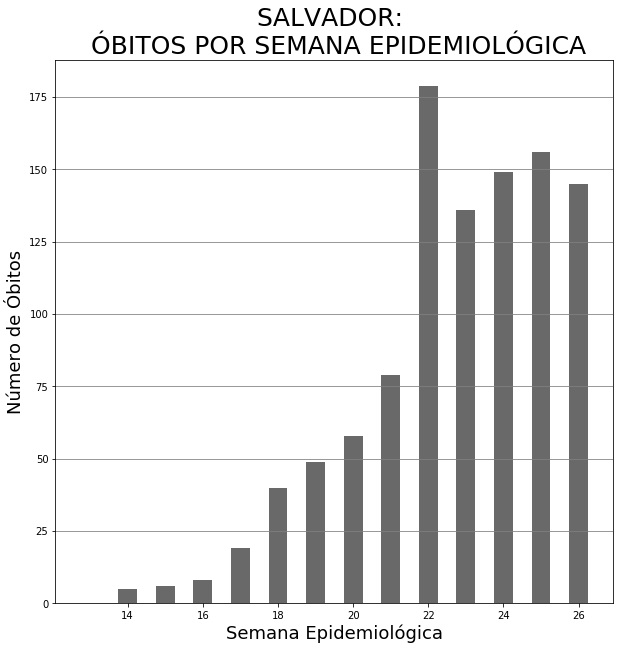

In [20]:
obitos_semana_local(df_cidade_sem, Muni)

### Baixando GeoJSon do estado

In [21]:
url = "https://raw.githubusercontent.com/luizpedone/municipal-brazilian-geodata/master/data/"
fname = uf.upper() + '.json'
path = os.path.abspath(os.getcwd())
print(path)
path = path + '\data\geojsonDL'
try:
    os.mkdir(path)
except FileExistsError:
    pass
filepath = path + '\\' + fname
get_file(filepath, url+fname )

d:\GitRepos\graficos_covid


'd:\\GitRepos\\graficos_covid\\data\\geojsonDL\\BA.json'

### Carregando arquivo GeoJson do estado

In [22]:
mapa = gpd.read_file(filepath, driver='GeoJSON')

In [23]:
mapa.bounds

minx      miny      maxx      maxy
0   -46.61667 -11.62453 -44.95797 -10.10756
1   -46.39744 -12.42868 -44.57863 -11.61847
2   -46.39057 -12.56396 -45.66124 -11.86280
3   -46.33072 -13.34792 -44.57732 -12.29024
4   -46.28202 -13.97949 -44.32860 -12.98920
..        ...       ...       ...       ...
412 -38.07961 -11.73795 -37.75290 -11.40263
413 -38.00532 -12.15452 -37.85466 -11.93328
414 -38.05812 -10.76395 -37.81358 -10.49518
415 -37.83007 -12.09129 -37.51480 -11.62987
416 -37.84196 -11.77174 -37.34080 -11.44139

[417 rows x 4 columns]

### Função gráfico: mapa de casos nos municípios por mil habitantes

In [24]:
def mapa_casos_estado(df, df_geo, uf, muni, nLevels):
    muniMapa = df.groupby('municipio')
    muniMapa = muniMapa.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'})
    mapaPlot = df_geo.join(muniMapa, on='NOME', how= 'left')

    mapaPlot.dropna(inplace=True)

    casos_p_habitante = mapaPlot['casosNovos']*1000 / mapaPlot['populacaoTCU2019']
    scheme = mapclassify.Quantiles(casos_p_habitante, k=nLevels)
    
    fig, ax1 = plt.subplots(1, 1, figsize=(20,15))

    geoplot.polyplot(df_geo, ax=ax1)

    plt.title('Covid - {} \nCasos Diagnosticados em cada município por mil habitantes'.format(uf), fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue=casos_p_habitante, scheme=scheme, ax=ax1,
        cmap='Reds', legend=True
    )
    plt.savefig( './data/output/' + uf.upper() + '_semana_casos_' + str(df['data'].max()).replace(":", "_") + '.png', format ='png')
    

### Função gráfico: mapa de óbitos nos municípios por mil habitantes

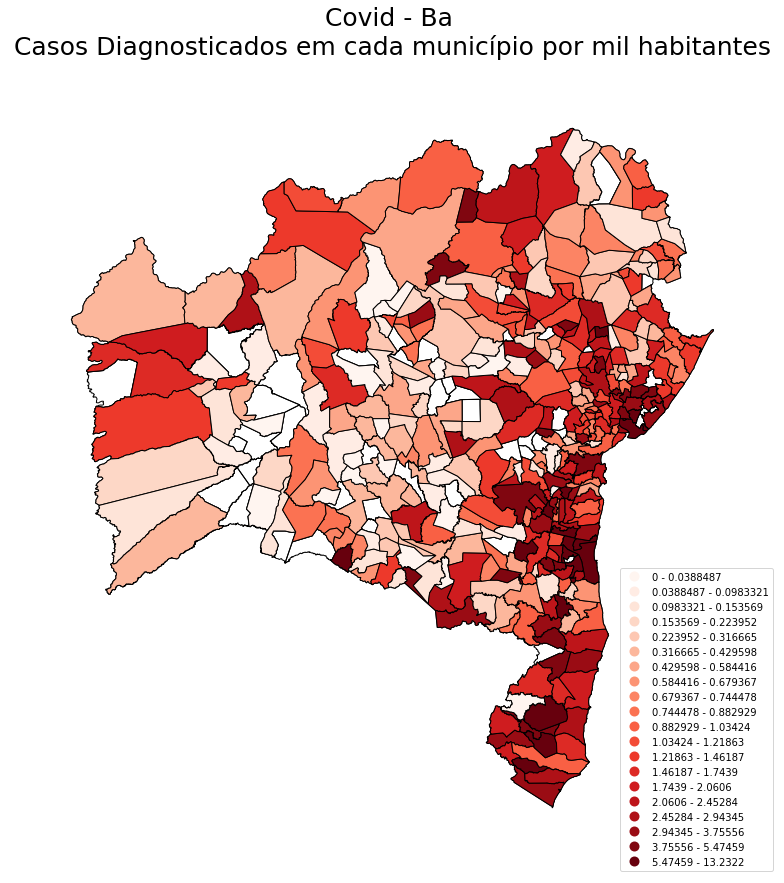

In [25]:
mapa_casos_estado(df_est, mapa, uf, Muni, 20)

In [26]:
def mapa_obitos_estado(df, df_geo, uf, nLevels):
    muniMapa = df.groupby('municipio')
    muniMapa = muniMapa.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'})
    mapaPlot = df_geo.join(muniMapa, on='NOME', how= 'left')

    mapaPlot.dropna(inplace=True)

    obitos_p_habitante = mapaPlot['obitosNovos']*1000 / mapaPlot['populacaoTCU2019']
    scheme = mapclassify.Quantiles(obitos_p_habitante, k=nLevels)

    fig, ax1 = plt.subplots(1, 1, figsize=(20,15))

    
    
    geoplot.polyplot(df_geo, ax=ax1)
    

    plt.title('Covid - {} \nÓbitos Registrados em Cada Município por Mil Habitantes'.format(uf), fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue=obitos_p_habitante, scheme=scheme, ax=ax1,
        cmap='Reds', legend=True
    )
    plt.savefig( './data/output/' + uf.upper() + '_semana_obitos_' + str(df['data'].max()).replace(":", "_") + '.png', format ='png')
    


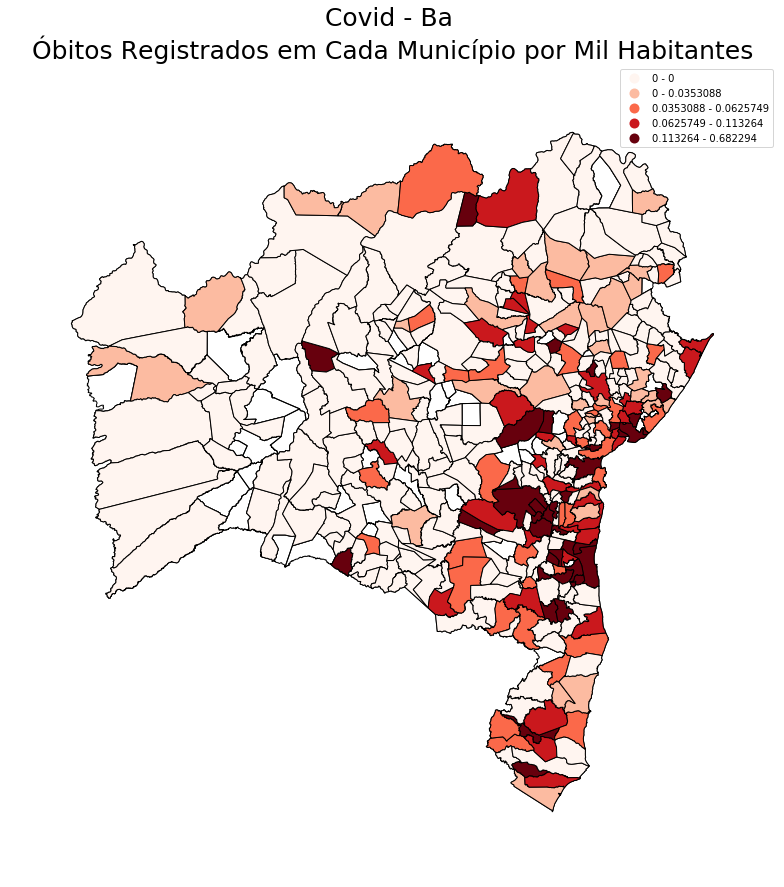

In [27]:
mapa_obitos_estado(df_est, mapa, uf, 10)